# Imports

## Libraries

In [1]:
from datetime import datetime, timedelta
import polars as pl
import json
import sys

In [2]:
sys.path.append('..')

from config.settings import Config

## Configurations

In [3]:
config = Config("dev")

## Data

In [3]:
# PATHS
morning_path = config.get_file("data", "morning_routine_v2.xlsx")
night_path = config.get_file("data", "night_routine_v2.xlsx")
json_path = config.get_file("misc", "rename_columns.json")

# DATA TABLES
df_sun_raw = pl.read_excel(morning_path)
df_moon_raw = pl.read_excel(night_path)

## Dictionaries

In [4]:
# Dict to translate dtype in STRING to dtype in POLARS
pl_dtype_dict = {
	"list": pl.List(pl.Utf8),
	"string": pl.Utf8,
	"date": pl.Date,
	"float": pl.Float64,
	"int": pl.Int64,
	"timestamp": pl.Datetime,
	"timedelta": pl.Duration
}

# Dict loading the rename_columns.json file
with open(json_path, encoding='utf-8') as f:
    rename_columns_dict = json.load(f)

## Functions

In [5]:
# Function to convert string to microseconds
def convert_to_microseconds(time_str):
    if time_str is not None:
        time_datetime = datetime.strptime(time_str, "%H:%M")
        difference = time_datetime - datetime.strptime("00:00", "%H:%M")
        microseconds = difference.total_seconds() * 1e6
        return int(microseconds)
    else:
        return None
    
def date_format_correction(date_var):
	# Turns date in the "MM-dd-yy" format to "YYYY-MM-dd" format
	return datetime.strptime(date_var, "%m-%d-%y").strftime("%Y-%m-%d")

# Data Cleaning

## Transformation Expessions

In [6]:
# Defining expression to rename columns when called
rename_expressions = [
    pl.col(column_name).alias(column_config["name"])
    for column_name, column_config in rename_columns_dict["morning"].items()
]

# Defining expression to correct columns dtype when called
dtype_expressions = [
    pl.col(column_config["name"]).cast(pl_dtype_dict[column_config["dtype"]])
    for column_name, column_config in rename_columns_dict["morning"].items()
]

## Applying Cleaning

In [7]:
# Applying expression to rename columns
df_sun = df_sun_raw.select(rename_expressions)

# Correction 'day_date' column from "MM-dd-yy" format to "YYYY-MM-dd" format
df_sun = df_sun.with_columns(
	pl.col("day_date").map_elements(lambda x: date_format_correction(x)).alias("day_date")
)

# List of columns that are going to be corrected to microseconds (and further in pl.Duration)
time_cols = ['day_form_time', 'slp_fall', 'pho_time', 'slp_raise', 'slp_duration']
# Applying 'convert_to_microseconds' function to the selected columns
df_sun = df_sun.select([
    pl.col(col_name).map_elements(convert_to_microseconds).alias(col_name)
    if col_name in time_cols
    else col_name
    for col_name in df_sun.columns
])

# Applying expression to change columns dtype
df_sun = df_sun.select(dtype_expressions)

In [8]:
wgt_columns = ["day_date",
			   "wgt_total",
			   "wgt_muscle",
			   "wgt_bf",
			   "wgt_rmr",
			   "wgt_cal"]

print(df_sun.select(wgt_columns).dtypes)

df_sun.select(wgt_columns).head()

[Date, Float64, Float64, Float64, Int64, Int64]


day_date,wgt_total,wgt_muscle,wgt_bf,wgt_rmr,wgt_cal
date,f64,f64,f64,i64,i64
2023-11-08,73.05,55.95,19.3,1598,897
2023-11-07,73.6,56.22,19.5,1604,541
2023-11-09,73.5,56.2,19.4,1603,609
2023-11-10,73.5,56.2,19.4,1603,829
2023-11-11,72.9,55.9,19.2,1594,1081


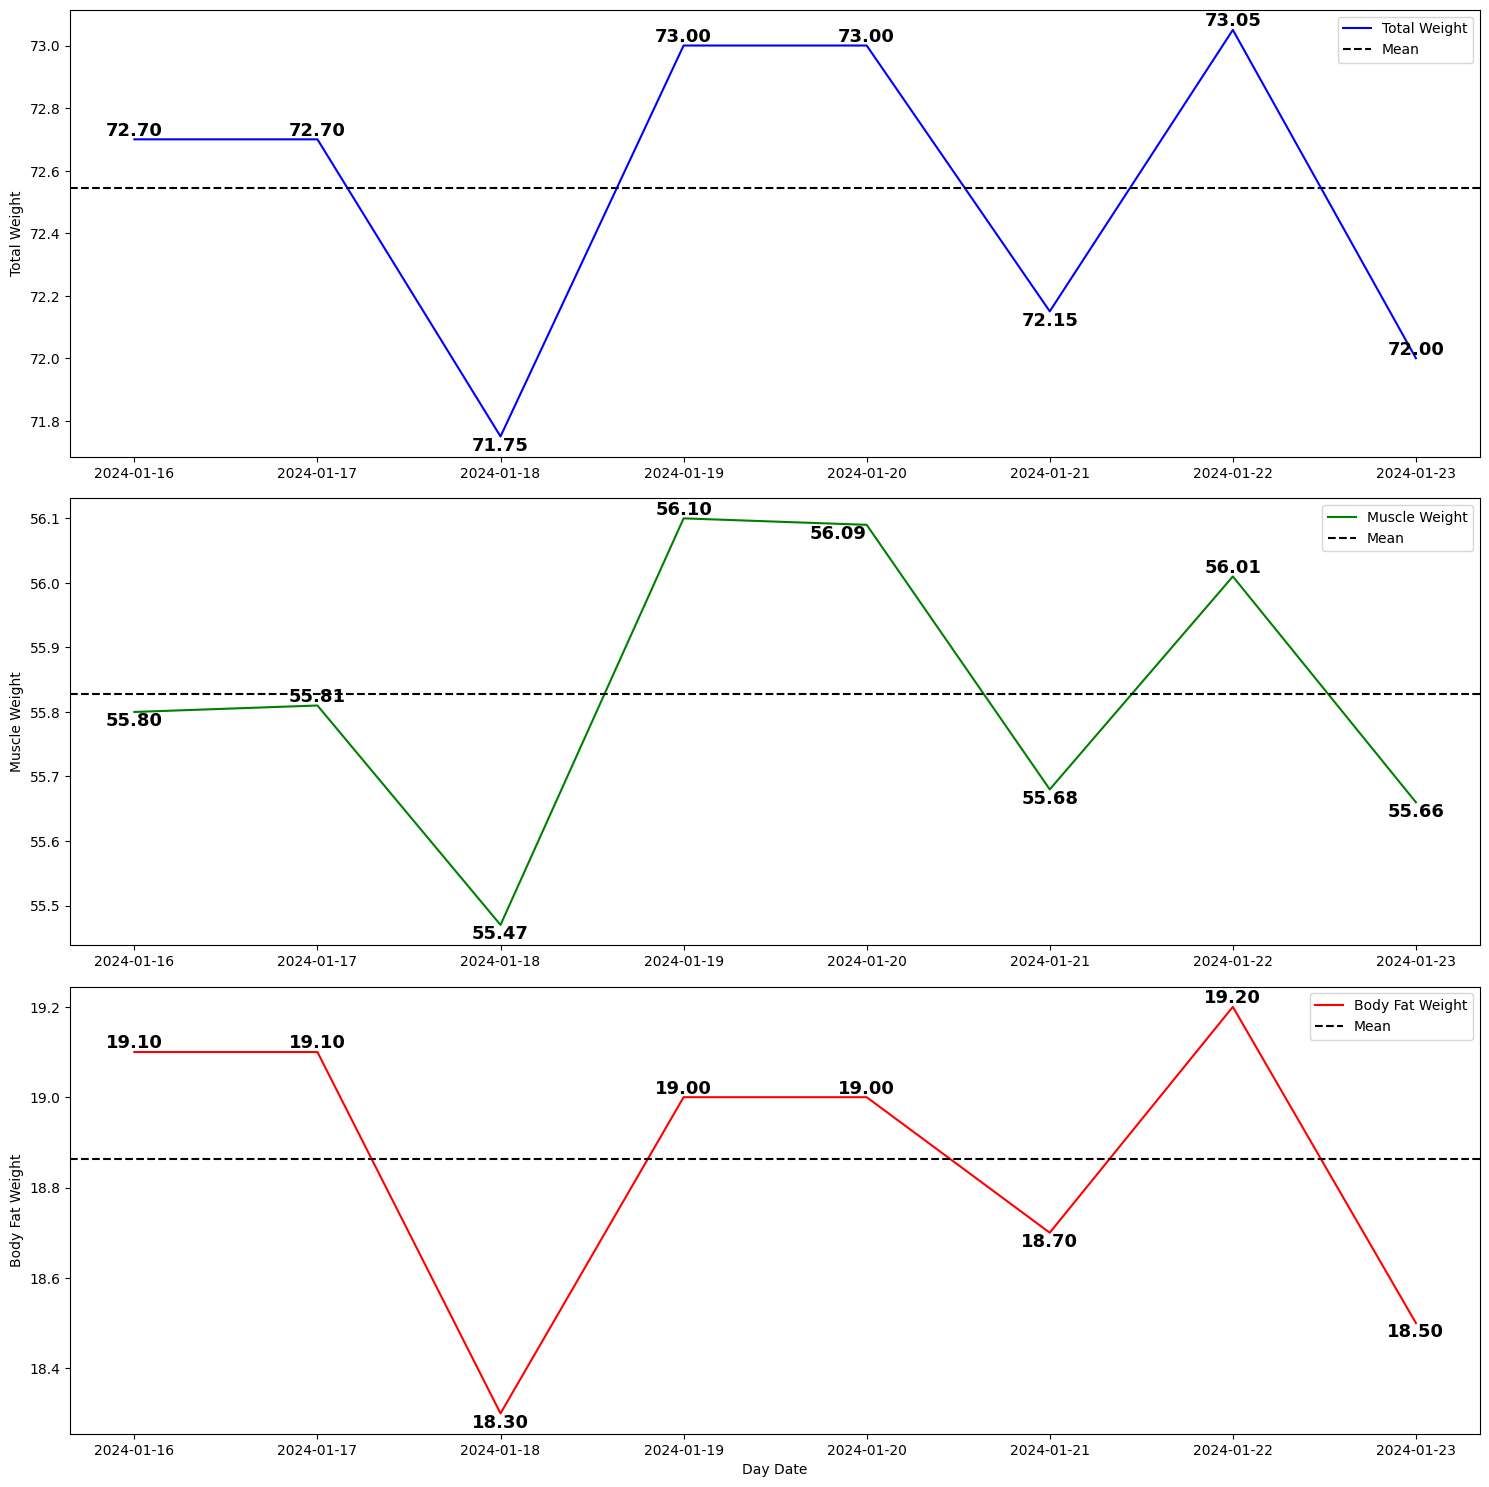

In [9]:
import matplotlib.pyplot as plt
import polars as pl

def decide_annotation_position(previous_value, current_value, next_value):
    if previous_value < current_value:
        if current_value < next_value:
            return "bottom", "center"
        elif current_value == next_value:
            return "bottom", "center"
        elif current_value > next_value:
            return "bottom", "center"
    elif previous_value == current_value:
        if current_value < next_value:
            return "top", "center"
        elif current_value == next_value:
            return "bottom", "center"
        elif current_value > next_value:
            return "bottom", "center"
    elif previous_value > current_value:
        if current_value < next_value:
            return "top", "center"
        elif current_value == next_value:
            return "bottom", "center"
        elif current_value > next_value:
            return "top", "right"
    return "bottom", "center"

# Ajustando as datas para exibir apenas a última semana
last_week_start = df_sun['day_date'].max() - pl.duration(weeks=1)
last_week_data = df_sun.filter(df_sun['day_date'] >= last_week_start)

# Plotando os gráficos individuais
plt.figure(figsize=(15, 15))

# Plot 1
plt.subplot(311)
plt.plot(last_week_data['day_date'], last_week_data['wgt_total'], label='Total Weight', color='blue')
plt.axhline(y=last_week_data['wgt_total'].mean(), color='black', linestyle='--', label='Mean')
plt.ylabel('Total Weight')
plt.legend()
for i, (date, value) in enumerate(zip(last_week_data['day_date'], last_week_data['wgt_total'])):
    previous_value = last_week_data['wgt_total'][i-1] if i > 0 else last_week_data['wgt_total'][i]
    next_value = last_week_data['wgt_total'][i+1] if i < len(last_week_data)-1 else last_week_data['wgt_total'][i]
    va, ha = decide_annotation_position(previous_value, value, next_value)
    plt.annotate(f'{value:.2f}', (date, value), textcoords="offset points", xytext=(0, 0), ha=ha, va=va, fontsize=13, fontweight='bold')

# Plot 2
plt.subplot(312)
plt.plot(last_week_data['day_date'], last_week_data['wgt_muscle'], label='Muscle Weight', color='green')
plt.axhline(y=last_week_data['wgt_muscle'].mean(), color='black', linestyle='--', label='Mean')
plt.ylabel('Muscle Weight')
plt.legend()
for i, (date, value) in enumerate(zip(last_week_data['day_date'], last_week_data['wgt_muscle'])):
    previous_value = last_week_data['wgt_muscle'][i-1] if i > 0 else last_week_data['wgt_total'][i]
    next_value = last_week_data['wgt_muscle'][i+1] if i < len(last_week_data)-1 else last_week_data['wgt_total'][i]
    va, ha = decide_annotation_position(previous_value, value, next_value)
    plt.annotate(f'{value:.2f}', (date, value), textcoords="offset points", xytext=(0, 0), ha=ha, va=va, fontsize=13, fontweight='bold')

# Plot 3
plt.subplot(313)
plt.plot(last_week_data['day_date'], last_week_data['wgt_bf'], label='Body Fat Weight', color='red')
plt.axhline(y=last_week_data['wgt_bf'].mean(), color='black', linestyle='--', label='Mean')
plt.xlabel('Day Date')
plt.ylabel('Body Fat Weight')
plt.legend()
for i, (date, value) in enumerate(zip(last_week_data['day_date'], last_week_data['wgt_bf'])):
    previous_value = last_week_data['wgt_bf'][i-1] if i > 0 else last_week_data['wgt_total'][i]
    next_value = last_week_data['wgt_bf'][i+1] if i < len(last_week_data)-1 else last_week_data['wgt_total'][i]
    va, ha = decide_annotation_position(previous_value, value, next_value)
    plt.annotate(f'{value:.2f}', (date, value), textcoords="offset points", xytext=(0, 0), ha=ha, va=va, fontsize=13, fontweight='bold')

# Ajustando o layout
plt.tight_layout()
plt.show()
